In [1]:
import torch
import torchvision
import gudhi as gd
from gudhi.wasserstein import wasserstein_distance

from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
%matplotlib inline

from ripser import lower_star_img
from ripser import Rips

import persim
import diagram2vec

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F

import gudhi as gd
from gudhi.wasserstein import wasserstein_distance as dist_w

from IPython.display import clear_output

POT (Python Optimal Transport) package is not installed. Try to run $ conda install -c conda-forge pot ; or $ pip install POT


In [3]:
mnist = loadmat("../data/mnist/mnist-original.mat")
X = mnist["data"].T
y = mnist["label"][0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
class MNIST_Dataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx].reshape(28, 28), self.y[idx]

In [5]:
batch_size = 8

train_dataset = MNIST_Dataset(X_train, y_train)
test_dataset = MNIST_Dataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [122]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
# device = 'cpu'

In [139]:
def diagram(image, sublevel=True):
    # get height and square image
    h = int(np.sqrt(image.shape[0]))
    image_sq = image.reshape((h,h))

    # create complex
    cmplx = gd.CubicalComplex(dimensions=(h, h), top_dimensional_cells=(sublevel*image))

    # get pairs of critical simplices
    cmplx.compute_persistence()
    critical_pairs = cmplx.cofaces_of_persistence_pairs()
    
    # get essential critical pixel
    bpx0_essential = critical_pairs[1][0][0] // h, critical_pairs[1][0][0] % h

    # get critical pixels corresponding to critical simplices
    try:
        bpx0 = [critical_pairs[0][0][i][0] for i in range(len(critical_pairs[0][0]))]
        dpx0 = [critical_pairs[0][0][i][1] for i in range(len(critical_pairs[0][0]))]
    except IndexError:
        bpx0 = []
        dpx0 = []
        
    try:
        bpx1 = [critical_pairs[0][1][i][0] for i in range(len(critical_pairs[0][1]))]
        dpx1 = [critical_pairs[0][1][i][1] for i in range(len(critical_pairs[0][1]))]
    except IndexError:
        bpx1 = []
        dpx1 = []
    

    flat_image = image_sq.flatten()
    pd0_essential = torch.tensor([[image_sq[bpx0_essential], torch.max(image)]])

    if (len(bpx0)!=0):
        pdb0 = flat_image[bpx0][:, None]
        pdd0 = flat_image[dpx0][:, None]
        pd0 = torch.Tensor(torch.hstack([pdb0, pdd0]))
        pd0 = torch.vstack([pd0, pd0_essential.to(device)])
    else:
        pd0 = pd0_essential

    if (len(bpx1)!=0):
        pdb1 = flat_image[bpx1][:, None]
        pdd1 = flat_image[dpx1][:, None]
        pd1 = torch.Tensor(torch.hstack([pdb1, pdd1]))
    else:
        pd1 = torch.zeros((1, 2))
    
    return pd0, pd1

class Diagram(nn.Module):
    def __init__(self):
        super(Diagram, self).__init__()
        
    def forward(self, x):
        diagrams = []
        for i in range(x.shape[0]):
            res = diagram(x[i].flatten())
            for j in range(len(res)):
                diagrams.append(torch.concatenate([res[j], torch.Tensor([[j, i] for _ in range(res[j].shape[0])]).to(device)], axis=1))
        diagrams = torch.concatenate(diagrams)
        return diagrams   

In [140]:
class Transformer(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out, seq_size=1024):
        super(Transformer, self).__init__()
        self.embeddings = nn.Linear(n_in, n_hidden)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=n_hidden, nhead=2, dim_feedforward=16, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer=self.encoder_layer, num_layers=2)
        self.classifier = nn.Linear(seq_size, n_out)

    def forward(self, X):
        X = self.embeddings(X)
        X = self.transformer(X)
        X = X.mean(dim=-1)
        X = self.classifier(X)
        X = X.softmax(dim=-1)
        return X

In [141]:
class TopologicalConvTransformer(nn.Module):
    def __init__(self, n_in, n_conv, max_sequence, n_diag, n_hidden, n_out):
        super(TopologicalConvTransformer, self).__init__()
        
        self.max_sequence = max_sequence
        self.conv = nn.Conv2d(n_in, n_conv, 3)
        self.diagram = Diagram()
        self.transformer = Transformer(n_diag, n_hidden, n_out, max_sequence)

    def forward(self, xs):
        result = []
        for i in range(xs.shape[0]):
            x = xs[i][None, :, :] / 256
            x = self.conv(x)
            x = self.diagram(x)
            if x.shape[0] > self.max_sequence:
                x = x[:self.max_sequence]
            x = F.pad(x, (0, 0, 0, self.max_sequence - x.shape[0]), "constant", 0)
            x = self.transformer(x)
            result.append(x[None, :])
        result = torch.concatenate(result, axis=0)
        return result
        

In [142]:
CLASS_NUM = 10

def fit(train_dataloader, test_dataloader, model, criterion, optimizer, epochs):
    best_model = deepcopy(model)
    best_loss = np.inf
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    for epoch in range(epochs):
        model.train()
        cur_train_loss = []
        cur_test_loss = []
        cur_train_accuracy = []
        cur_test_accuracy = []
        for batch in tqdm(train_dataloader):
            optimizer.zero_grad()
            target = batch[1].long().to(device)
            output = model(batch[0].to(device))
            loss = criterion(output, F.one_hot(target, CLASS_NUM).float())
            loss.backward()
            optimizer.step()
            cur_train_loss.append(loss.item())
            cur_train_accuracy.append((output.argmax(-1) == target).float().mean().item())

        with torch.no_grad():
            for batch in tqdm(test_dataloader):
                target = batch[1].long().to(device)
                output = model(batch[0].to(device))
                loss = criterion(output, F.one_hot(target, CLASS_NUM).float())
                cur_test_loss.append(loss.item())
                cur_test_accuracy.append((output.argmax(-1) == target).float().mean().item())

        clear_output()

        train_losses.append(np.mean(np.array(cur_train_loss)))
        test_losses.append(np.mean(np.array(cur_test_loss)))
        train_accuracies.append(np.mean(np.array(cur_train_accuracy)))
        test_accuracies.append(np.mean(np.array(cur_test_accuracy)))

        print(f'{epoch}: train_accuracy={train_accuracies[-1]}, test_accuracy={test_accuracies[-1]}, train_loss={train_losses[-1]}, test_loss={test_losses[-1]}')
        if test_losses[-1] < best_loss:
            print(f'Save the new best model')
            best_model = deepcopy(model)
            best_loss = test_losses[-1]

        plt.subplot(1, 2, 1)
        plt.plot(np.arange(epoch+1), test_accuracies, label='test_accuracy')
        plt.plot(np.arange(epoch+1), train_accuracies, label='train_accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(np.arange(epoch+1), test_losses, label='test_loss')
        plt.plot(np.arange(epoch+1), train_losses, label='train_loss')
        plt.legend()

        plt.show()
    return best_model

In [144]:
device = 'cpu'

0: train_accuracy=0.3595714285714286, test_accuracy=0.48192857142857143, train_loss=0.252819341812815, test_loss=0.2147751483959811
Save the new best model


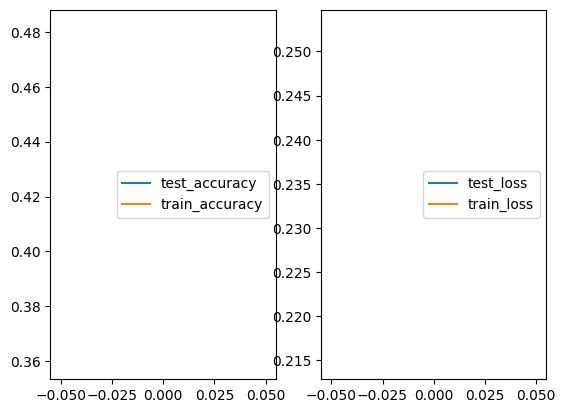

 14%|█▍        | 980/7000 [01:10<07:10, 13.99it/s]


KeyboardInterrupt: 

In [146]:
model = TopologicalConvTransformer(n_in=1, n_conv=4, max_sequence=256, n_diag=4, n_hidden=32, n_out=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))
criterion = nn.BCELoss()
best_model = fit(train_loader, test_loader, model, criterion, optimizer, 100)